In [5]:
import gym
import os
from gym.envs.toy_text.frozen_lake import generate_random_map
from matplotlib import pyplot as plt
from cmdscreen import CMDScreen
from Sarsa0 import Sarsa0
import numpy as np

In [188]:
screen = CMDScreen()


env = gym.make("FrozenLake-v1", desc=["SFFFFFFF", "FFFFFFFF", "FFFFFFFF","FFFFFFFF",
                                      "FFFFFFFF","FFFFFFFF","FFFFFFFF","FFFFFFFF",],
               map_name="8x8", is_slippery=False)

env.reset()



0

In [189]:
class WindyGridworld():
    def __init__(self, is_eight_action = False, ninth_action = False):
        # origin is defined as left_lower corner. and start from 1
        # namely cols are : 1 2 3 4 5 6 7 8 9 10
        # rows are : 1 2 3 4 5 6 7
        # we start from (1, 4)
        self.xlimit = 10
        self.ylimit = 7
        self.is_eight_action = is_eight_action
        self.ninth_action = ninth_action
        # we use explicit dictionary instead of function to accelerate training
        self.wind_dict = { 1: 0, 2: 0, 3: 0, 4: 1, 5: 1,
                           6: 1, 7: 2, 8: 2, 9: 1, 10: 0 }

    def step(self, pos, action):
        x, y = pos
        wind = self.wind_dict[x]
        if action == 'left':
            next_state = max(1, x-1), min(y+wind, self.ylimit)
        elif action == 'right':
            next_state = min(self.xlimit, x+1), min(y+wind, self.ylimit)
        elif action == 'up':
            next_state = x, min(y+wind+1, self.ylimit)
        elif action == 'down':
            next_state = x, max(0, min(y+wind-1, self.ylimit))
        else:
            if self.is_eight_action:
                if action == 'left-up':
                    next_state = max(1, x-1), min(y+wind+1, self.ylimit)
                elif action == 'left-down':
                    next_state = max(1, x-1), max(0,min(y+wind-1, self.ylimit))
                elif action == 'right-up':
                    next_state = min(self.xlimit, x+1), min(y+wind+1, self.ylimit)
                elif action == 'right-down':
                    next_state = min(self.xlimit, x+1), max(0,min(y+wind-1, self.ylimit))
                else:
                    if self.ninth_action:
                        if action == 'stay':
                            next_state = x, max(0,min(y+wind, self.ylimit))
                        else:
                            raise ValueError
                    else:
                        raise ValueError
            else:
                raise ValueError
        if next_state == (8, 4):
            return next_state, 0
        else:
            return next_state, -1


In [190]:
env = WindyGridworld()

In [191]:
env.step( (1,2) ,"right")

((2, 2), -1)

### Parameters

In [192]:
alpha = 0.15
eps = 0.1
gamma = 1.0
n_episodes = 15000

In [364]:
# INITIALIZE Q
# Q is abritrarily initialized for all the states except terminal ones.. where Q(terminalS, :) = 0
# ldru
Q = np.ones((7*10,9))*0.5
Q[8*4 - 1][:] = 0
# we know 5, 7, 11, 12, 15 are terminal
# Q[5][:] = 0
# Q[7][:] = 0
# Q[11][:] = 0
# Q[12][:] = 0
# Q[63][:] = 0
Q[:,2]

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5])

In [203]:
# 0 is 1 so we have to go idx => tup(with 0s as 1s), 0-> 1,1 - 1-> 1,2
def to_tuple(s):
    x = s//10 + 1
    y = s%10 + 1
    return (y,x)

In [209]:
to_tuple(66)

(7, 7)

In [210]:
def from_tuple(s):
#     print(s)
    return (s[1]-1)*10 + s[0]-1

In [211]:
from_tuple((7,7))

66

In [353]:
class EnvWrapper:
    def __init__(self, env):
        self.env = env
        self.actions = {
            0:"left",
            1:"down",
            2: "right",
            3: "up",
            4: "left-up",
            5: "left-down",
            6: "right-up",
            7: "right-down",
            8:"stay"
        }
    def step(self, s, a):
#         print(s)
#         based on the next step this should move the thing up
        s = to_tuple(s)
        return self.env.step(s, self.actions[a])
    
    
        

In [354]:
def get_action(eps, Q, s):
    r = np.random.random()
#     print(s)
    if r < eps:
        a = np.random.randint(0,9)
    else:
        a = np.argmax(Q[s])
    return a

In [360]:
env = EnvWrapper(WindyGridworld(is_eight_action= True, ninth_action=True))

In [365]:
# env.reset()
s = 3
# time_i_4 = []
# time_i_8 = []
time_i_9 = []
for e in range(n_episodes):
    
    done = False
    a = get_action(eps, Q, s)
    t = 0
    while not done:
        t+=1
#         print(s, a)
        s_, r = env.step(s, a)
#         print(s_)
        s_ = from_tuple(s_)
        
        a_ = get_action(eps, Q, s_)
    
        Q[s][a] = Q[s][a] + alpha*(r + gamma*Q[s_][a_] - Q[s][a])
        s=s_
        a=a_
#     env.reset()
        if r == 0:
            time_i_9.append(t)
#             print("done")
            done = True
            s = 3

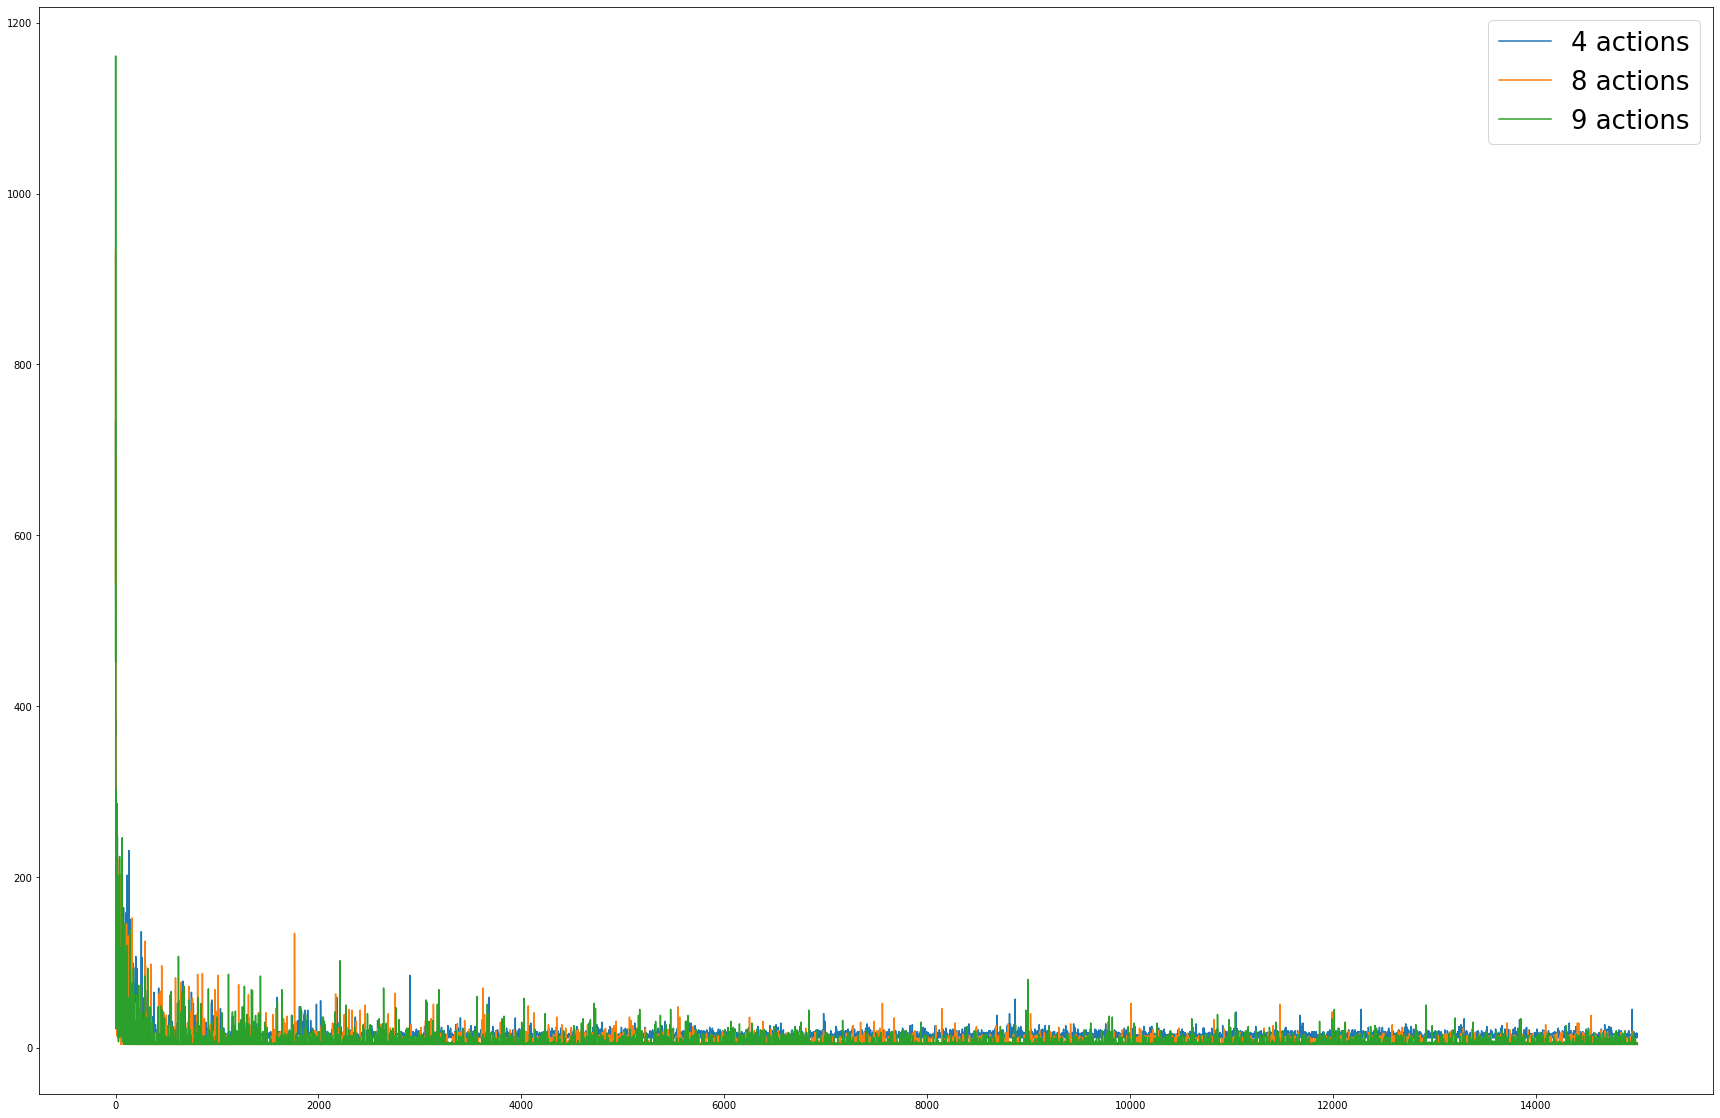

In [373]:
plt.figure(figsize=(30,20))
plt.plot(time_i_4, label="4 actions")
plt.plot(time_i_8, label="8 actions")
plt.plot(time_i_9, label="9 actions")
plt.legend(loc=0, prop={'size': 26})
# plt.legend()

# With Smoothing

In [394]:
def smooth_by(arr, space):
    arr = np.array(arr)
    avg_arr = arr[:]
    for i in range(space, len(arr)-space):
        avg_arr[i] =arr[i:i+space].mean()
    return avg_arr

In [397]:
smoothed_t1 = smooth_by(time_i_4, 20)
smoothed_t2 = smooth_by(time_i_8, 20)
smoothed_t3 = smooth_by(time_i_9, 20)

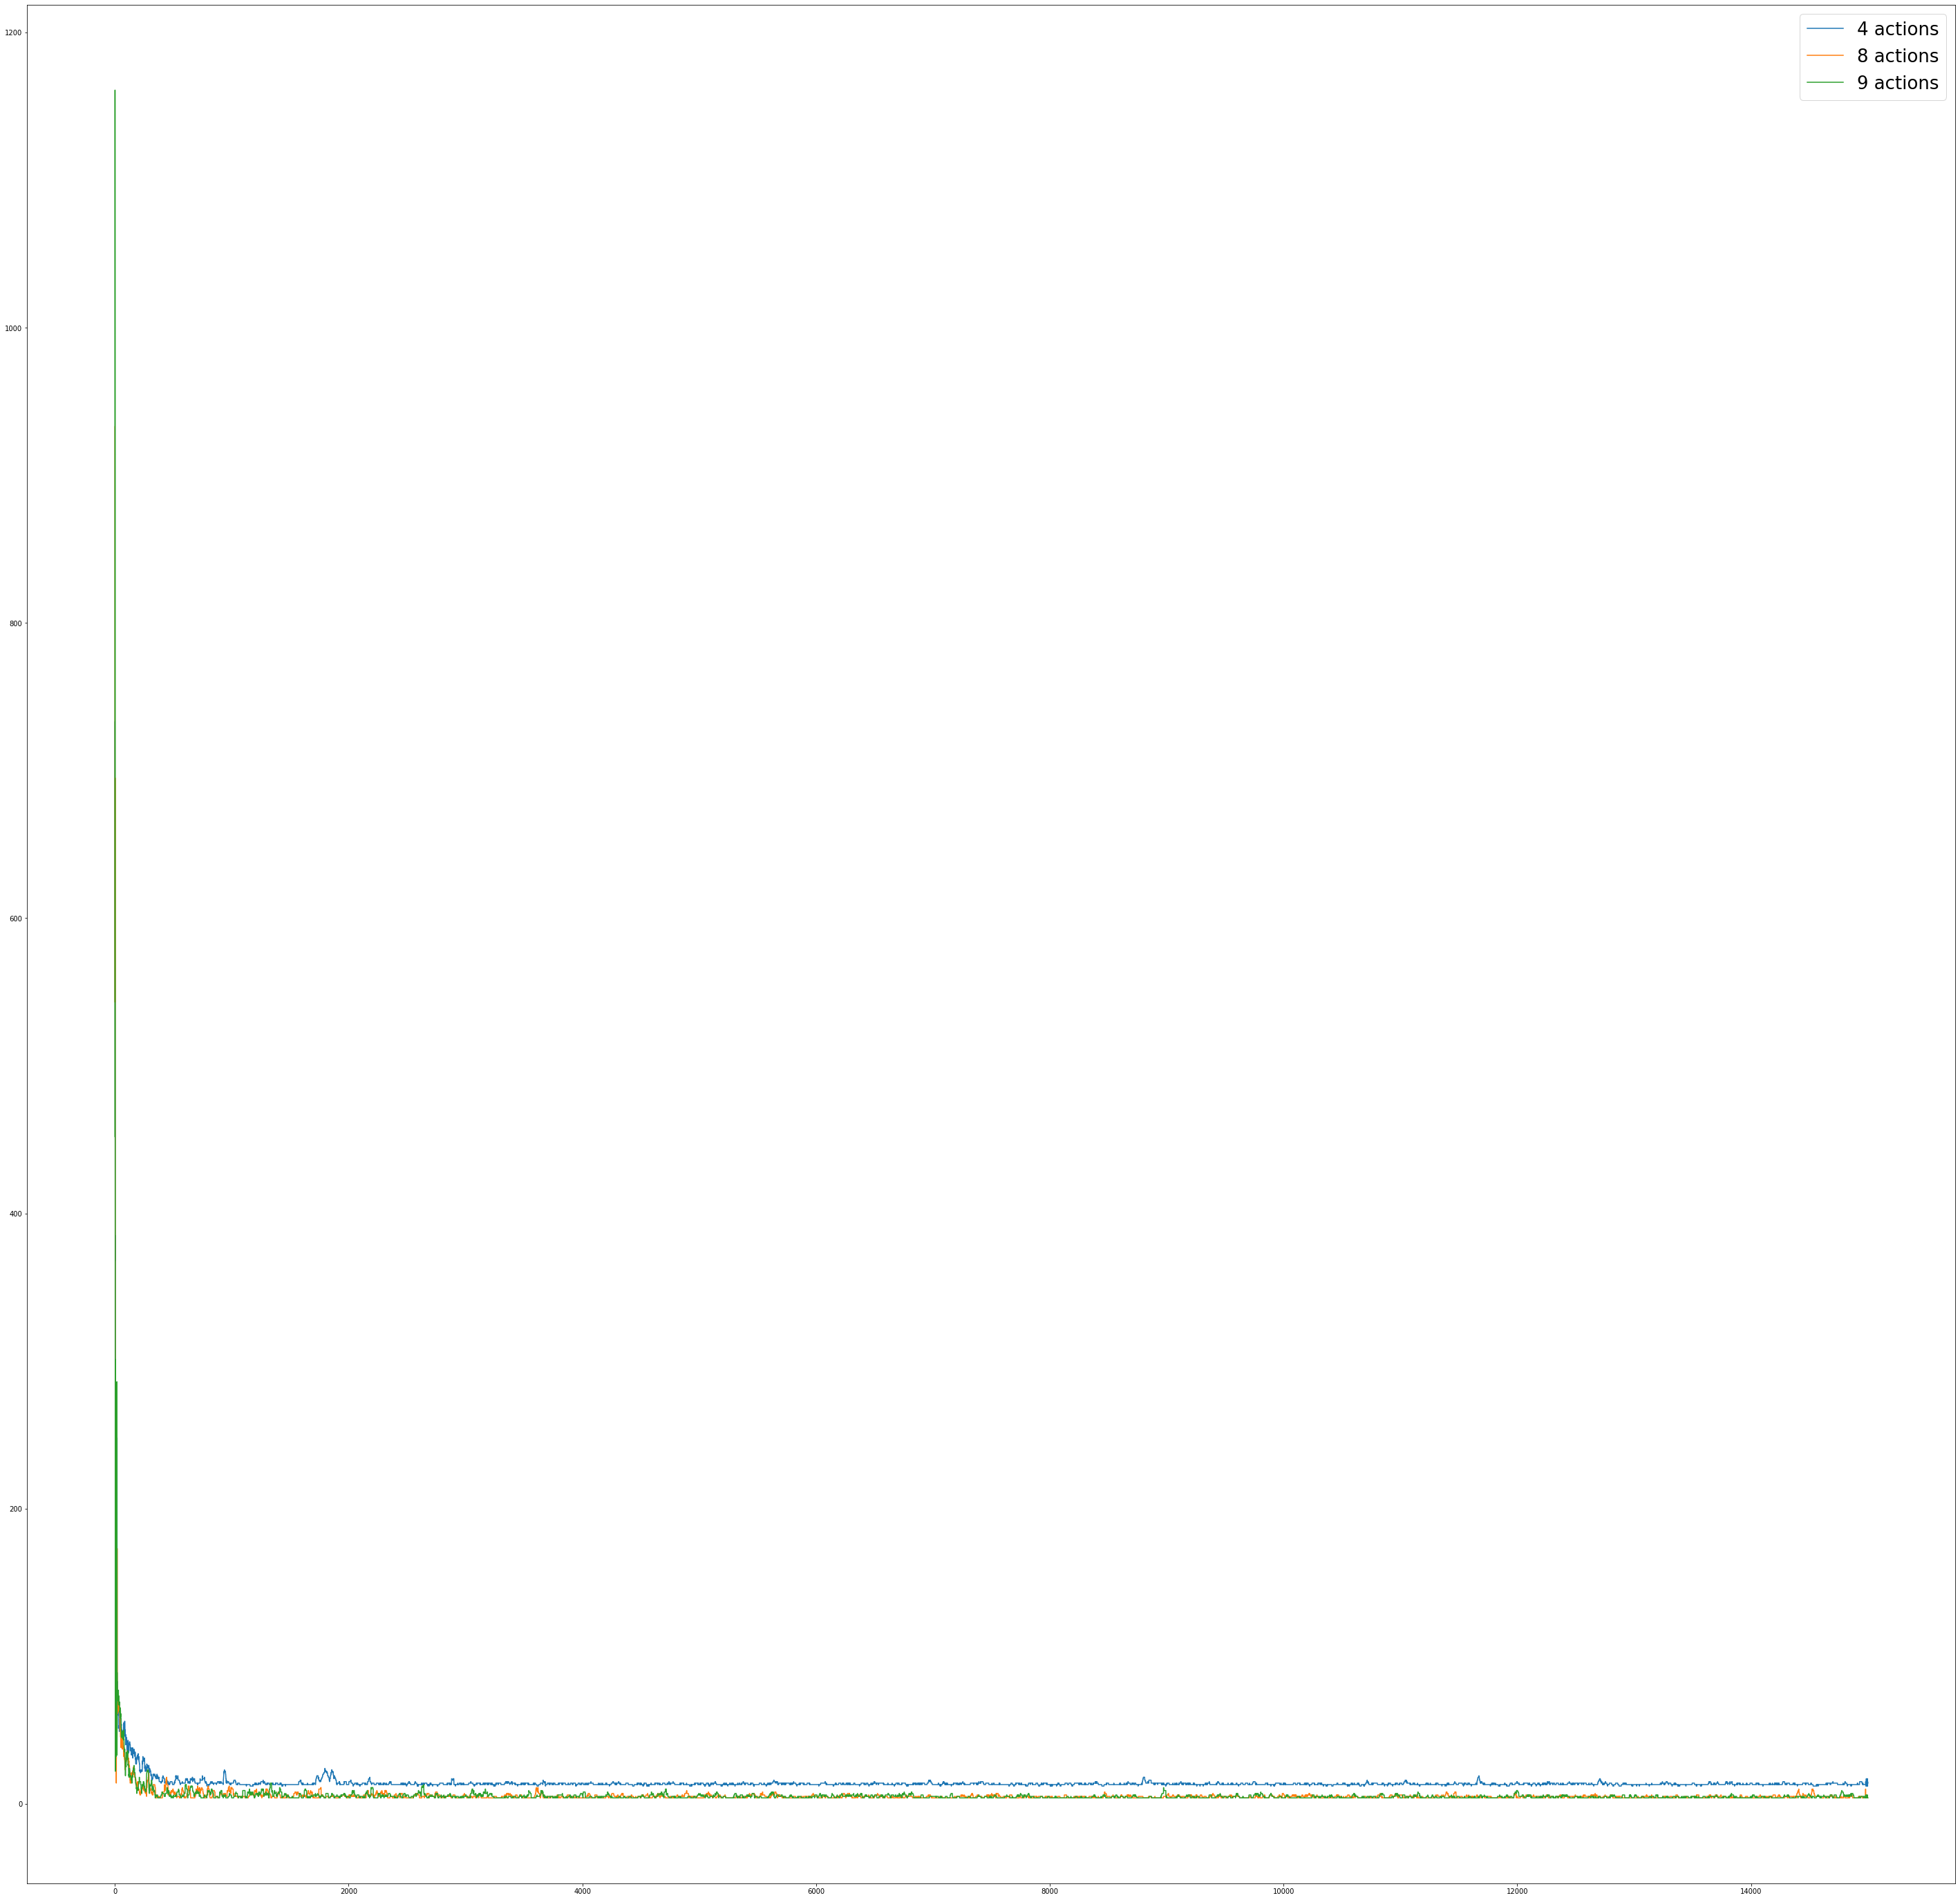

In [404]:
plt.figure(figsize=(50,50))
# plt.ylim(0,50)

plt.plot(smoothed_t1, label="4 actions")
plt.plot(smoothed_t2, label="8 actions")
plt.plot(smoothed_t3, label="9 actions")
plt.legend(loc=0, prop={'size': 26})
# plt.legend()

In [374]:
get_action(eps, Q, 0)

5

In [218]:
get_action(eps, Q, 0)

0

In [56]:
Q

array([[0.54620215, 0.54619634, 0.54620351, 0.54620217],
       [0.54620412, 0.54618913, 0.5461951 , 0.54620358],
       [0.54621423, 0.54605523, 0.5462083 , 0.54618623],
       [0.5462172 , 0.54618559, 0.54616446, 0.54619882],
       [0.54620647, 0.54600343, 0.54580608, 0.54602878],
       [0.54644972, 0.53785801, 0.54645484, 0.54454333],
       [0.54579815, 0.50661082, 0.54480174, 0.54180293],
       [0.52929186, 0.53794672, 0.53651555, 0.53712484],
       [0.54620038, 0.54616609, 0.54615318, 0.54620458],
       [0.54621185, 0.54598825, 0.54579531, 0.5462113 ],
       [0.54624543, 0.53878461, 0.54460575, 0.54619087],
       [0.54628892, 0.53690805, 0.54189614, 0.54449404],
       [0.54550944, 0.50599992, 0.5143126 , 0.50741094],
       [0.54798689, 0.5       , 0.5       , 0.50798932],
       [0.52374757, 0.5       , 0.5       , 0.50678966],
       [0.5       , 0.53650634, 0.53161298, 0.53717762],
       [0.54620752, 0.54495841, 0.54609406, 0.5462192 ],
       [0.54629329, 0.54313483,

In [69]:
a = get_action(eps, Q, s)
s = env.step(a)[0]
env.render()

  (Up)
SFFFFFFF
FFFFFFFF
FFFFFFFF
FFFFFFFF
FFFFFFFF
FFFFFFFF
FFFFFFFF
FFFFFFFF


In [318]:
def print_states(state, goal):
    
    for i in range(7):
        for j in range(10):
            if state[0]-1 == i and state[1]-1 == j:
                print("\033[1;3;42m - \033[0m", end="")
            elif goal[0]-1 == i and goal[1]-1 == j:
                print("\033[1;3;44m - \033[0m", end="")
            else:
                print(" - ", end="")
        print("\n")
            

In [319]:
print_states((2,1),(4,8))

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 



In [228]:
env.env.step((7,7), "down")

((7, 7), -1)

In [252]:
print("\033[1;3;42m Bright Green  \n")

 Bright Green  



In [255]:
print("as")

as


In [305]:
s = 3
s_ = to_tuple(s)
print_states( (s_[0], s_[1] ) , (4,8))

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 



In [410]:
s_, r = env.step(s, a)
#         print(s_)
print_states( (s_[1], s_[0] ) , (4,8))
s = from_tuple(s_)
        
a = get_action(0.0, Q, s)


 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

 -  -  -  -  -  -  -  -  -  - 

